### Agent Based Modelling With Rabbits and cadCAD

* Agent structure and attributes
* Evolution strategies
* Logistic Function
* Parameter Design
* AB Testing and Monte Carlo Simulation
* Vectorization 


Rabbits will have two attributes  
1. Speed (0,10)
2. Appetite (0,10)

The total food consumption of the population is the sum of appetites across all rabbits. 

Assumptions  
1. The environment has a limited supply of food. Use logistic function to model this.
2. \# Offspring is a function of Appetite and Total Population of Rabbits. #offspring = round(appetite/2) * log(rabbit_population)
3. More speed = More Feed
4. There is a constant amount of wolves. Rabbits are eaten inversely proportional to speed

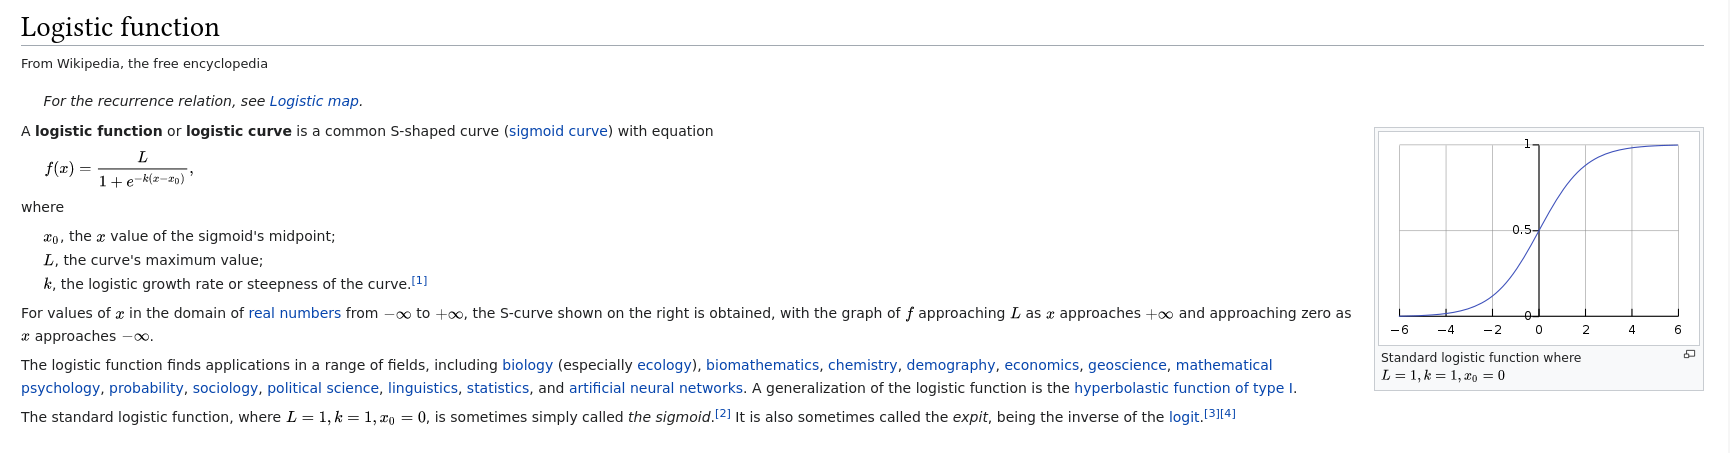

In [2]:
import numpy as np
import param as pm
import hvplot.pandas
import panel as pn
import pandas as pd

class Logistic(pm.Parameterized):
    maximum = pm.Number(1, softbounds=(-10, 10), doc='The curves maximum value. (L)')
    midpoint = pm.Number(0, softbounds=(-10, 10), doc="The x value of the simoid's midpoint. (x0)")
    growth_rate = pm.Number(1, softbounds=(-10, 10), doc="The logistic growth rate or steepness of the curve. (k)")
    domain_scale = pm.Number(10, softbounds=(1,100), doc="Scale of the domain of the x axis. Does not effect f.")
    
    def f(self,x):
        return self.maximum / (1 + np.exp(-self.growth_rate*(x - self.midpoint)))
    
    def xs(self):
        scale = 1+(self.domain_scale / max(abs(self.growth_rate),1))
        xs = np.linspace(self.midpoint-scale, self.midpoint+scale, 1000)  
        return xs
    
    def curve(self):
        xs = self.xs()
        ys = self.f(xs)
        df = pd.DataFrame({"x":xs, "y":ys})
        return df
    
    def view(self):
        curve = self.curve()
        return curve.hvplot(x="x",y="y") 
    
l = Logistic()

pn.Column(l, l.view)

Column
    [0] Column(margin=5, name='Logistic', width=300)
        [0] StaticText(value='<b>Logistic</b>')
        [1] FloatSlider(end=10, name='Maximum', start=-10, value=1)
        [2] FloatSlider(end=10, name='Midpoint', start=-10)
        [3] FloatSlider(end=10, name='Growth rate', start=-10, value=1)
        [4] FloatSlider(end=100, name='Domain scale', start=1, value=10)
    [1] ParamMethod(method)

In [3]:
class FoodConstraint(Logistic):
    maximum = pm.Number(10, softbounds=(0,10), precedence=-1)
    midpoint = pm.Number(7500, softbounds=(5000,10000), precedence=-1)
    growth_rate = pm.Number(-0.0005, softbounds=(-0.01,0), step=0.0005, precedence=-1)
    domain_scale = pm.Number(1000, softbounds=(100,2000), precedence=-1)
    x_start = pm.Number(0, doc="Minimum x value", precedence=-1)
    x_end = pm.Number(10000, doc="Minimum x value", precedence=-1)
    domain_scale = pm.Number(precedence=-1)
    
    def xs(self):
        xs = np.linspace(self.x_start, self.x_end, 1000)  
        return xs
    
    def view(self):
        curve = self.curve()
        curve = curve.rename(columns={'x':'Population Food Consumption','y':'Survival by Appetite'})
        return curve.hvplot(x='Population Food Consumption',y='Survival by Appetite', title='Food Constraint Model')

In [4]:
food_constraint_model = FoodConstraint()

pn.Column(food_constraint_model, food_constraint_model.view)

Column
    [0] StaticText(value='<b>FoodConstraint</b>')
    [1] ParamMethod(method)

In [5]:
import numpy as np
import pandas as pd
import hvplot.pandas
import param
import panel as pn

class WolvesModel(param.Parameterized):
    predetor_rate = param.Number(0.5, bounds=(0,1), step=0.1)
    intercept = param.Number(10, bounds=(1,10), step=0.5)
    x_start = pm.Number(0, doc="Minimum x value", precedence=-1)
    x_end = pm.Number(10, doc="Minimum x value", precedence=-1)
    
    def f(self, x):
        return x*(-self.predetor_rate / self.intercept) + self.predetor_rate
    
    def xs(self):
        xs = np.linspace(self.x_start, self.x_end, 1000)  
        return xs
    
    def curve(self):
        xs = self.xs()
        ys = self.f(xs)
        ys = np.where(ys<0, 0, ys)
        df = pd.DataFrame({"x":xs, "y":ys})
        return df
    
    def view(self):
        curve = self.curve()
        curve = curve.rename(columns={'x':'Speed of Rabbit','y':'Chance Eaten by Wolves'})
        return curve.hvplot(x='Speed of Rabbit',y='Chance Eaten by Wolves', title='Predation rate by speed')

In [6]:
w = WolvesModel()

In [7]:
pn.Column(w, w.view)

Column
    [0] Column(margin=5, name='WolvesModel', width=300)
        [0] StaticText(value='<b>WolvesModel</b>')
        [1] FloatSlider(name='Predetor rate', value=0.5)
        [2] FloatSlider(end=10, name='Intercept', start=1, step=0.5, value=10)
    [1] ParamMethod(method)

In [9]:
import math
import pandas as pd
import numpy as np
import plotly
import hvplot.pandas


pd.options.plotting.backend = "plotly"

from cadCAD.configuration.utils import config_sim

from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

from cadCAD.configuration import Experiment
from cadCAD import configs

SIMULATION_TIMESTEPS = 20
food_constraint_model = FoodConstraint()
wolf_model_1 = WolvesModel(predetor_rate=0.5)
wolf_model_2 = WolvesModel(predetor_rate=0.7)


rabbits = [
    {
        'speed': 5,
        'appetite': 5,
    }
]

initial_state = {
    'rabbits': rabbits,
    'total_population': len(rabbits),
}

system_params = {
    'increase': [food_constraint_model],
    'decrease': [wolf_model_1, wolf_model_2],
}

In [10]:
rabbit = rabbits[0]

rabbit

{'speed': 5, 'appetite': 5}

In [11]:
offspring = 3
new_rabbits = []
for i in range(offspring):
    new_rabbit = rabbit.copy()
    new_rabbit['speed'] += (np.random.random() - 0.5) * 0.1
    new_rabbit['appetite'] += (np.random.random() - 0.5) * 0.1
    new_rabbits.append(new_rabbit)

In [12]:
new_rabbits

[{'speed': 4.964082307881684, 'appetite': 5.012405323356573},
 {'speed': 5.038782843797637, 'appetite': 4.967918257379233},
 {'speed': 4.982800800980418, 'appetite': 5.014312631938711}]